# Climate Informatics 2023 paper plots



In [1]:
import copy

# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import os
if os.path.exists("01_data_processor_and_loader.ipynb"):
    os.chdir('..')  # relocate IPython from notebooks/ sub-dir up to root
print(f'Your cwd is: {os.getcwd()}')

Your cwd is: /data/hpcdata/users/tomand/code/deepsensor


In [3]:
# TEMP not using GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
from tqdm.notebook import tqdm

import tensorflow as tf

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from deepsensor.plot.downscaling import set_global_fontize
from matplotlib import gridspec

from deepsensor.analyse.validate import model_config_dict_to_model_dict
from deepsensor.plot.utils import plot_stations
import numpy as np
import pandas as pd
import xarray as xr
import scipy


from deepsensor.data.loader import DataLoader
from deepsensor.data.getters import get_spatiotemporal_data, get_placement_df
from deepsensor.data.processor import unnormalise_coord_tensor
from deepsensor.data.getters import get_coord_names

import string
import seaborn as sns
import matplotlib as mpl
from celluloid import Camera
from matplotlib import ticker
from deepsensor.data.getters import get_gridded_X_target_from_coords
from deepsensor.data.getters import get_auxiliary_data


2023-02-13 15:19:16.351785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Set up

In [5]:
folder = 'climate_informatics_plots'
if not os.path.exists(folder): os.makedirs(folder)

In [6]:
set_global_fontize(8)
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['text.usetex'] = False
mpl.rc('mathtext', default='regular')

sns.set_style('white')

crs = ccrs.LambertAzimuthalEqualArea(0, -90)
subplot_kw = {'projection': crs}

linewidth = 5.66  # inches

gb = 3.5e6  # Square grid boundary (half of the side length in projected coordinates)

In [7]:
region = 'antarctica'
data_processor_ID = "2022_12_17_1822_deepsensor_antarctica"

gridded_var_ID = 'tas_anom'

date = '2018-06-01'


In [8]:
models = {
    "ARConvGNP": {
        "model_kind": "ARConvCNP",
        "data_loader_ID": "2022_12_15_sim_tas_anom",
        "model_ID": "2022_12_18_0225_convgnp_tas_anom_new_unet_flat128",
        "seed": 42,
        "best_or_latest": "latest"
    },
    "ConvGNP": {
        "model_kind": "ConvGNP",
        "data_loader_ID": "2022_12_15_sim_tas_anom",
        "model_ID": "2022_12_18_0225_convgnp_tas_anom_new_unet_flat128",
        "seed": 42,
        "best_or_latest": "latest"
    },
    "Gibbs GP": {
        "model_kind": "GaussianProcess",
        "data_loader_ID": "2022_12_15_sim_tas_anom",
        "kernel_ID": "Gibbs",
        "gibbs_basis_funcs": 100,
        "context_set_idx": 0
    },
    "EQ GP": {
        "model_kind": "GaussianProcess",
        "data_loader_ID": "2022_12_15_sim_tas_anom",
        "kernel_ID": "EQ",
        "context_set_idx": 0
    }
}


In [9]:
true_da = get_spatiotemporal_data(region, 'interim', gridded_var_ID, use_dask=True)

In [10]:
data_loaders = {}
for model_config in models.values():
    data_loader = DataLoader(
        region, model_config['data_loader_ID'],
        use_dask=True, verbose_level=0)

    data_loaders[model_config['data_loader_ID']] = data_loader

In [11]:
model_dict = model_config_dict_to_model_dict(models, region)
model_strs = list(models.keys())

2023-02-13 15:20:11.476147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 15:20:12.136188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7395 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1




Gibbs GP hyperparameters:
basis_fn.limits: [-1.1  1.1]
basis_fn.count: 100.0
hypers.basis_fn.scale: [0.022]
basis_fn.locs:
    (10000x2 array of data type float64)
    [[-1.   -1.  ]
     [-1.   -0.98]
     [-1.   -0.96]
     ...
     [ 1.    0.96]
     [ 1.    0.98]
     [ 1.    1.  ]]
weights[0]: [0.017 0.019 0.02  ... 0.02  0.019 0.017]
weights[1]: [0.017 0.02  0.023 ... 0.021 0.02  0.016]
hypers.variance: 1.317
noise:      4.748e-03
mean:       0.1028





EQ GP hyperparameters:
noise:      0.03858
mean:       -2.569e-03
variance:   0.6467
scale[x1]:  0.1061
scale[x2]:  0.1073





In [12]:
land_ID = 'land_500m'
land_mask = get_auxiliary_data(region, 'interim', land_ID)
land_mask = land_mask.coarsen(
    **{'x': 10, 'y': 10},
    boundary='pad').mean()


### Samples plot

In [13]:
model_str = 'ConvGNP'

model_config = models[model_str]
data_loader = data_loaders[model_config['data_loader_ID']]
model = model_dict[model_str]

date = '2018-01-01'
context_sim_locs_date = '2009-02-15'
datasets = [data_loader(date, context_sim_locs='station', context_sim_locs_date=context_sim_locs_date)]

if model_config['model_kind'] == 'GaussianProcess':
    with tf.device('/cpu:0'):
        pred_ds = model.predict_ongrid2(
            datasets=datasets,
            reference_grid=true_da,
            region=region,
            data_processor_ID=data_processor_ID,
            data_loader=data_loader,
            pred_types=['mean_std', 'samples'],
            downscaling_factor=0.4 if model_config['model_kind'] == 'GaussianProcess' else 1,
        )
else:
    pred_ds = model.predict_ongrid2(
        datasets=datasets,
        reference_grid=true_da,
        region=region,
        data_processor_ID=data_processor_ID,
        data_loader=data_loader,
        pred_types=['mean_std', 'samples'],
        downscaling_factor=0.4 if model_config['model_kind'] == 'GaussianProcess' else 1,
        ar_subsample_factor=4,
    )



2023-02-13 13:49:48.989607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


In [14]:
def samples_figure(
    region, pred_ds, dataset, data_loader, date, crs, data_processor_ID,
    gridded_var_ID, results_folder, context_sim_locs='station', n_samples=4,
    mask_ID=None, land_ID=None, centre_point=None, size=None,
    add_axis_letters=False,
):
    coord_names = get_coord_names(region, data_processor_ID)

    # TEMP: If multi-target prediction, only plot first variable
    target_set_idx = 0
    var_idx = 0
    target_data = data_loader.config['target_data'][target_set_idx]
    var_ID = target_data['var_IDs'][var_idx]

    # interim_var_ID = data_loader.config['sim_processed_to_interim_mapping'][var_ID]
    lowres_da = get_spatiotemporal_data(
        region, 'interim', gridded_var_ID, use_dask=True)
    # region, 'interim', interim_var_ID, use_dask=True)

    if mask_ID is not None:
        mask_da = get_auxiliary_data(region, 'interim', mask_ID)
        lowres_da = lowres_da.where(
            mask_da.interp_like(lowres_da, method='nearest'), np.nan)
        pred_ds = pred_ds.where(
            mask_da.interp_like(pred_ds, method='nearest'), np.nan)

    if land_ID is not None:
        ### Get hi-res Antarctic land contour
        land_mask = get_auxiliary_data(region, 'interim', land_ID)
        land_ds = land_mask.coarsen(
            **{coord_names['x2']: 5, coord_names['x1']: 5},
            boundary='pad').mean()

    if centre_point is None and size is not None:
        centre_point = (0, 0)
    if centre_point is not None and size is not None:
        y_crop = (centre_point[0] + size / 2, centre_point[0] - size / 2)
        x_crop = (centre_point[1] - size / 2, centre_point[1] + size / 2)
        pred_ds = pred_ds.sel({coord_names['x1']: slice(*y_crop), coord_names['x2']: slice(*x_crop)})
        lowres_da = lowres_da.sel({coord_names['x1']: slice(*y_crop), coord_names['x2']: slice(*x_crop)})
    else:
        y_crop = (pred_ds[coord_names['x1']].max(), pred_ds[coord_names['x1']].min())
        x_crop = (pred_ds[coord_names['x2']].min(), pred_ds[coord_names['x2']].max())

    pred_ds = pred_ds.sel(time=date)
    lowres_da = lowres_da.sel(time=date)

    if var_ID == 'clt_abs':
        pred_ds = xr.where(pred_ds < 0, 0, pred_ds)
        pred_ds = xr.where(pred_ds > 1, 1, pred_ds)
        # lowres_da = xr.where(lowres_da <= 0.1, np.nan, lowres_da)

    extent = (*x_crop, *y_crop[::-1])

    var_clim = (
        min(lowres_da.min().compute(), pred_ds.samples.min().compute()),
        max(lowres_da.max().compute(), pred_ds.samples.max().compute()),
    )

    subplot_kw = {'projection': crs}
    # Ensure colorbars don't exceed range of axis
    if var_ID == 'tas_abs':
        cbar_label = r"Temperature ($^\circ C$)"
        cmap = 'jet'
    elif var_ID == 'tas_anom':
        # cbar_label = "Temperature\n" + r"anomaly ($^\circ C$)"
        cbar_label = "Temperature anomaly ($^\circ C$)"
        cmap = 'seismic'
    elif var_ID == 'clt_abs':
        cbar_label = "Cloud cover fraction"
        # cmap = 'Greys_r'
        cmap = 'Greys'
    else:
        cbar_label = ""
        cmap = 'jet'

    cbar_kwargs = dict(fraction=0.046, pad=0.04, label=cbar_label)

    ncols = 1 + n_samples
    # nrows = 1
    figheight = linewidth / ncols  # Square axes with space for title

    # fig_samples, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(6, figheight), subplot_kw=subplot_kw)
    # axes = axes.ravel()
    fig = plt.figure(figsize=(linewidth, figheight))
    axes = []

    outer = gridspec.GridSpec(1, 3, figure=fig, wspace=0.03, width_ratios=(1, n_samples, 0.05))
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
    gs2 = gridspec.GridSpecFromSubplotSpec(1, n_samples, subplot_spec=outer[1], wspace=0.)
    gs3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[2])

    ax = fig.add_subplot(gs1[0], projection=crs)
    # lowres_da.plot(ax=ax, cmap=cmap, vmin=var_clim[0], vmax=var_clim[1], add_colorbar=False)
    lowres_da.plot(
        ax=ax, cmap=cmap, vmin=var_clim[0], vmax=var_clim[1], add_colorbar=False,
        alpha=lowres_da if var_ID == 'clt_abs' else 1,
    )
    axes.append(ax)

    # TEMP? Select random samples
    sample_seeds = np.random.choice(pred_ds.sample.sample.size, n_samples, replace=False)
    for sample_i in range(n_samples):
        ax = fig.add_subplot(gs2[sample_i], projection=crs)
        # im = pred_ds['samples'].sel(sample=sample_i).\
        #     plot(ax=ax, cmap=cmap, vmin=var_clim[0], vmax=var_clim[1],
        #          add_colorbar=False)
        im = pred_ds['samples'].sel(sample=sample_seeds[sample_i]).plot(
            ax=ax, cmap=cmap, vmin=var_clim[0], vmax=var_clim[1], add_colorbar=False,
            alpha=pred_ds['samples'].sel(sample=sample_seeds[sample_i]) if var_ID == 'clt_abs' else 1)
        axes.append(ax)

    cax = fig.add_subplot(gs3[0])
    plt.colorbar(im, cax, **cbar_kwargs)

    # Plot the context point-based data
    plot_stations(axes, dataset, data_processor_ID, region, color='k', s=2 ** 2, linewidths=0.25)
    for i, ax in enumerate(axes):
        ax.set_extent(extent, crs=crs)
        if var_ID == 'clt_abs':
            ax.stock_img()
        if land_ID is not None:
            land_ds.plot.contour(ax=ax, colors='k', levels=[0.5], linewidths=0.25, zorder=20)
        # else:
        #     ax.coastlines(linewidth=0.25)
        ax.coastlines(linewidth=0.25, zorder=21)

        if add_axis_letters:
            t = ax.text(0.015, 0.015, string.ascii_lowercase[i], transform=ax.transAxes,
                    weight='bold')
            t.set_bbox(dict(facecolor='white', linewidth=0, pad=1))

    # ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1))

    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_title('Ground truth', pad=3)
        else:
            ax.set_title(f'Sample {i}', pad=3)
    # plt.tight_layout()
    return fig


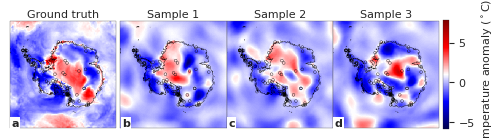

In [15]:
fig = samples_figure(
    region, pred_ds, datasets[0], data_loader, date, crs, data_processor_ID,
    gridded_var_ID, folder, context_sim_locs='station', n_samples=3,
    mask_ID=None, land_ID=None, centre_point=None, size=None,
    add_axis_letters=True,
)


In [22]:

# plt.subplots_adjust(wspace=0.0, hspace=0)#, top=0.8)

fig_folder = os.path.join(folder, 'samples')
if not os.path.exists(fig_folder): os.makedirs(fig_folder)
fname = f'samples_{model_str}_{date}'
fpath = os.path.join(fig_folder, fname)
fig.savefig(fpath+'.png', facecolor='white', dpi=300, bbox_inches='tight')
fig.savefig(fpath+'.pdf', facecolor='white', dpi=300, bbox_inches='tight')
print(f"Figure saved to {fpath}")
plt.close()


Figure saved to climate_informatics_plots/samples/samples_ConvGNP_2018-06-01


### Prior covariance comparison

In [17]:
date = '2018-06-01'

In [40]:
n_t = 50
# n_t = 100
x1_coords = np.linspace(1, -1, n_t)
x2_coords = np.linspace(-1, 1, n_t)
X_target = get_gridded_X_target_from_coords(x1_coords, x2_coords)

gb = 3.5e6

# x1s = ([0.2, -0.6], [0.5, 0.], [0, 0.72])
# x1s = ([0.5, 0.], [0, 0.3], [0, 0.69])
x1s = ([-0.2, 0.], [0, 0], [0, 0.69])
x1s = ([-0.27, 0.02], [0, 0], [0, 0.69])
# x1s = ([-0.2, 0.], [0, 0], [0, 0.85])
x1s = [np.array(x1).reshape(2, 1) for x1 in x1s]

gridspec_kw = {'wspace': 0.00, 'hspace': 0.00}
subplot_kw = {'projection': crs}

# model_names = ['ConvGNP', 'Gibbs GP', 'EQ GP']
model_names = ['ConvGNP']
titles = ['Ross Ice Shelf', 'South Pole', 'East Antarctica']

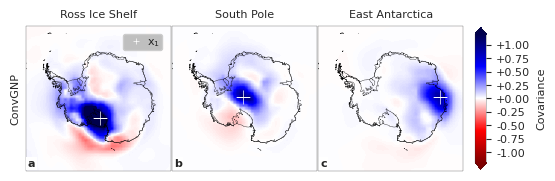

In [41]:
def gen_cov_plot():
    ncols = len(x1s)
    nrows = len(model_names)
    fig, axes = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(linewidth, linewidth * nrows / ncols),
        gridspec_kw=gridspec_kw, subplot_kw=subplot_kw)
    if nrows == 1:
        axes = np.array(axes)[np.newaxis, :]

    dataset = data_loader(date)
    dataset['X_context'][0] = np.array([], dtype='float32').reshape(2, 0)
    dataset['Y_context'][0] = np.array([], dtype='float32').reshape(1, 0)
    dataset['X_target'][0] = X_target
    cov_list = []
    for model_str in model_names:
        model = model_dict[model_str]
        dist = model(dataset)
        cov = model.covariance(dist)
        cov_list.append(cov)

    for j, cov in enumerate(cov_list):
        cov_x1s = []
        for i, x1 in enumerate(x1s):
            dists_all = np.linalg.norm(X_target - x1, axis=0)
            x1_idx = np.argmin(dists_all)
            cov_x1 = cov[x1_idx].reshape(n_t, n_t).copy()
            cov_x1s.append(cov_x1)
        # clim = (-1, 1)
        clim = (-1.2, 1.2)
        # clim=None
        for i, (x1, cov_x1) in enumerate(zip(x1s, cov_x1s)):
            ax = axes[j, i]
            ax.set_extent((-gb, gb, -gb, gb), crs=ccrs.LambertAzimuthalEqualArea(0, -90))

            dists_all = np.linalg.norm(X_target - x1, axis=0)
            x1_idx = np.argmin(dists_all)

            x_t = unnormalise_coord_tensor(data_processor_ID, region, X_target)[:, x1_idx:x1_idx + 1]
            im = ax.imshow(cov_x1, extent=(-gb, gb, -gb, gb), cmap='seismic_r', clim=clim,
                           origin='upper')

            ax.coastlines(linewidth=0.25)
            land_mask.plot.contour(colors='k', levels=[0.5], linewidths=0.25, subplot_kw={'projection': crs}, ax=ax)
            ax.scatter(*x_t[::-1], color='white', marker='+', s=10 ** 2, label=r'$x_1$',
                       linewidths=0.5, zorder=20)
            # if i == len(x1s) - 1:
            #     cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f',
            #                        label='Covariance')
            #     plt.colorbar(im, cax=axes[j, len(x1s)], **cbar_kwargs)

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

            if i == j == 0:
                leg = ax.legend(bbox_to_anchor=(.95, .95), loc='upper right', facecolor=[0.75, 0.75, 0.75], framealpha=1, borderaxespad=0.1, borderpad=0.2, ncol=2, columnspacing=3, handletextpad=0.025, markerscale=0.5)

            if j == 0:
                ax.set_title(titles[i])

    for i in range(len(cov_list)):
        axes[i, 0].set_ylabel(model_names[i])

    for i, ax in enumerate(axes.ravel()):
        t = ax.text(0.015, 0.03, string.ascii_lowercase[i], transform=ax.transAxes,
                    weight='bold')
        t.set_bbox(dict(facecolor='white', linewidth=0, pad=1))

    from matplotlib import ticker
    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.75])
    cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f', label='Covariance')
    cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs, extend='both')
    tick_locator = ticker.MaxNLocator(nbins=11)
    cb.locator = tick_locator
    cb.update_ticks()

gen_cov_plot()

fname = f"cov_comparison_{'_'.join(model_names)}"
fpath = os.path.join(folder, fname)
plt.savefig(fpath+'.png', dpi=300, bbox_inches='tight')
plt.savefig(fpath+'.pdf', dpi=300, bbox_inches='tight')
plt.show()


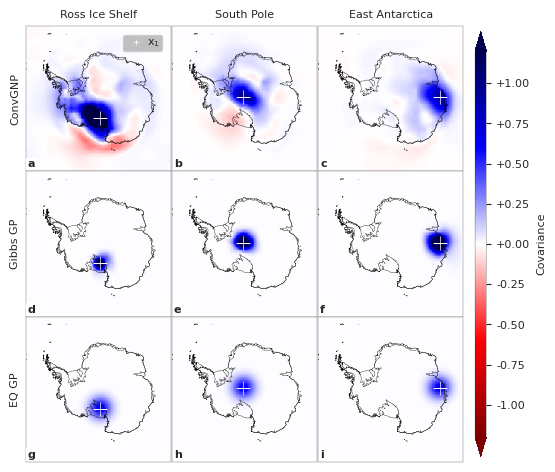

In [42]:

model_names = ['ConvGNP', 'Gibbs GP', 'EQ GP']
gen_cov_plot()

fname = f'cov_comparison'
fpath = os.path.join(folder, fname)
plt.savefig(fpath+'.png', dpi=300, bbox_inches='tight')
plt.savefig(fpath+'.pdf', dpi=300, bbox_inches='tight')
plt.show()



### Prior covariance over time

In [43]:
dates = ['2018-01-22', '2018-06-21']
n_t = 140
x1_coords = np.linspace(1, -1, n_t)
x2_coords = np.linspace(-1, 1, n_t)
X_target = get_gridded_X_target_from_coords(x1_coords, x2_coords)

gb = 3.5e6

# x1s = ([0.2, -0.6], [0.5, 0.], [0, 0.72])
# x1s = ([0.5, 0.], [0, 0.3], [0, 0.69])
# x1s = ([-0.2, 0.], [0, 0], [0, 0.69])
x1s = ([-0.27, 0.02], [0, 0], [0, 0.69])
# x1s = ([-0.27, 0.02], [0, 0], [0.8, 0.8])
# x1s = ([-0.2, 0.], [0, 0], [0, 0.85])
x1s = [np.array(x1).reshape(2, 1) for x1 in x1s]

gridspec_kw = {'wspace': 0.00, 'hspace': 0.00}

# model_names = ['ConvGNP']
model_str = 'ConvGNP'
model = model_dict[model_str]
titles = ['Ross Ice Shelf', 'South Pole', 'East Antarctica']

In [44]:
cov_list = []
for date in dates:
    dataset = data_loader(date)
    dataset['X_context'][0] = np.array([], dtype='float32').reshape(2, 0)
    dataset['Y_context'][0] = np.array([], dtype='float32').reshape(1, 0)
    dataset['X_target'][0] = X_target
    dist = model(dataset)
    cov = model.covariance(dist)
    cov_list.append(cov)

2023-02-13 14:00:22.762668: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1536640000 exceeds 10% of free system memory.
2023-02-13 14:00:26.159597: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1536640000 exceeds 10% of free system memory.


0.66659325
0.36357045
0.36310634
3.6100032
1.0379273
0.944876


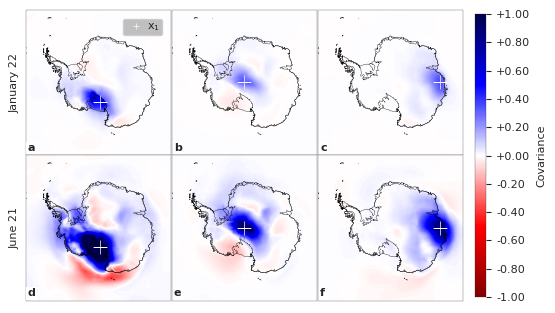

In [46]:
nrows = len(dates)
ncols = len(x1s)
fig, axes = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(linewidth, linewidth * nrows / ncols),
    gridspec_kw=gridspec_kw, subplot_kw=subplot_kw)

cbar_ims = []
clims = []
label_i = 0
for j, cov in enumerate(cov_list):
    cov_x1s = []
    for i, x1 in enumerate(x1s):
        dists_all = np.linalg.norm(X_target - x1, axis=0)
        x1_idx = np.argmin(dists_all)
        cov_x1 = copy.deepcopy(cov[x1_idx])
        print(cov_x1[x1_idx])
        cov_x1 = cov_x1.reshape(n_t, n_t)
        cov_x1s.append(cov_x1)
    clim = (-1, 1)
    # TEMP make clim along row
    # clim = (-np.max(np.abs(cov_x1s)), np.max(np.abs(cov_x1s)))
    clims.append(clim)
    for i, (x1, cov_x1) in enumerate(zip(x1s, cov_x1s)):
        ax = axes[j, i]

        if j == 0:
            ax.set_title(titles[i])

        dists_all = np.linalg.norm(X_target - x1, axis=0)
        x1_idx = np.argmin(dists_all)

        x_t = unnormalise_coord_tensor(data_processor_ID, region, X_target)[:, x1_idx:x1_idx + 1]
        im = ax.imshow(cov_x1, extent=(-gb, gb, -gb, gb), cmap='seismic_r',
                       clim=(-1, 1),
                       origin='upper')
        # ax.contour(cov_x1 / cov[x1_idx, x1_idx], extent=(-gb, gb, -gb, gb),
        #             levels=[-1, 0.],
        #             linewidths=0.25, colors='k',
        #             linestyles='--',
        #             # negative_linestyle='--',
        #             origin='upper')
        # mpl.rc('hatch', color='k', linewidth=.1)
        # ax.contourf(cov_x1 / cov[x1_idx, x1_idx], extent=(-gb, gb, -gb, gb),
        #            levels=[-1, 0.],
        #            linewidths=0.25, colors='k',
        #            linestyles='--',
        #             hatches=['xxxx'],
        #            # negative_linestyle='--',
        #             alpha=0.,
        #            origin='upper')

        ax.set_extent((-gb, gb, -gb, gb), crs=ccrs.LambertAzimuthalEqualArea(0, -90))
        ax.coastlines(linewidth=0.25)  # TODO?
        land_mask.plot.contour(colors='k', levels=[0.5], linewidths=0.25, ax=ax)
        # ax.scatter(*x_t[::-1], color='white', marker='o', facecolors='none', s=3 ** 2, label=r'$\mathbf{x}_1$',
        #            linewidths=0.5, zorder=20)
        ax.scatter(*x_t[::-1], color='white', marker='+', s=10 ** 2, label=r'$x_1$',
                   linewidths=0.5, zorder=20)
        if i == len(x1s) - 1:
            cbar_ims.append(im)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.set_xlabel('')
        if i == 0:
            axes[j, 0].set_ylabel(pd.Timestamp(dates[j]).strftime('%B %d'))

        if i == j == 0:
            leg = ax.legend(bbox_to_anchor=(.95, .95), loc='upper right', facecolor=[0.75, 0.75, 0.75], framealpha=1, borderaxespad=0.1, borderpad=0.2, ncol=2, columnspacing=3, handletextpad=0.025, markerscale=0.5)

        t = ax.text(0.015, 0.03, string.ascii_lowercase[label_i], transform=ax.transAxes,
                    weight='bold')
        t.set_bbox(dict(facecolor='white', linewidth=0, pad=1))
        label_i += 1

# plt.tight_layout()
# TODO remove spaceing?¬
# plt.subplots_adjust(left=0.05, right=0.8)


from matplotlib import ticker
# Add single colorbar to right of figure
cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.75])
# cbar_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
# cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f', label='Covariance')
cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f',
                   label='Covariance',
                   )
# plt.colorbar(im, cax=axes[j, len(x1s)], **cbar_kwargs)
# plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)
cb = plt.colorbar(im, cax=cbar_ax,
                  # ticks=np.linspace(clims[j][0], clims[j][1], 7),
                  **cbar_kwargs)
tick_locator = ticker.MaxNLocator(nbins=11)
cb.locator = tick_locator
cb.update_ticks()

# for j, im in enumerate(cbar_ims):
#     # cax = fig.add_axes([0.85, 0.05 + (len(cbar_ims) - j - 1) / len(cbar_ims), 0.02, 1 / len(cbar_ims)])
#     # cbar = fig.colorbar(im, cax=cax, orientation='vertical')
#     # cbar.ax.tick_params(labelsize=8)
#     # cbar.set_label('Covariance', fontsize=8)
#
#     cbar_pos_new = [cbar_pos.x0 + cbar_pos.width + 0.01, cbar_pos.y0 + 0.1 * cbar_pos.height, cbar_pos.width * 0.05, cbar_pos.height * 0.8]
#     cbar_ax = fig.add_axes(cbar_pos_new)
#     # axes[j, len(x1s)].set_position(cbar_pos_new)
#
#     cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f', label='Covariance')
#     # plt.colorbar(im, cax=axes[j, len(x1s)], **cbar_kwargs)
#     # plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)
#     cb = plt.colorbar(im, cax=cbar_ax,
#                  # ticks=np.linspace(clims[j][0], clims[j][1], 7),
#                  **cbar_kwargs)
#     tick_locator = ticker.MaxNLocator(nbins=7)
#     cb.locator = tick_locator
#     cb.update_ticks()

# plt.subplots_adjust(wspace=0, hspace=0)

fname = f'cov_over_time_convgnp'
fpath = os.path.join(folder, fname)
plt.savefig(fpath + '.png', dpi=300, bbox_inches='tight')
plt.savefig(fpath + '.pdf', dpi=300, bbox_inches='tight')
plt.show()


### Change in correlation over time

1.0
1.0
1.0
1.0
1.0
1.0
-0.24645235 0.15661727
-0.054826815 0.17457975
-0.14583778 0.1762743


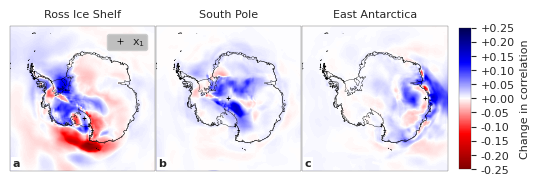

In [48]:
nrows = 1
ncols = len(x1s)
fig, axes = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(linewidth, linewidth * nrows / ncols),
    gridspec_kw=gridspec_kw, subplot_kw=subplot_kw)

cbar_ims = []
clims = []
label_i = 0

cov_foo = []
for j, cov in enumerate(cov_list):
    cov_x1s = []
    for i, x1 in enumerate(x1s):
        dists_all = np.linalg.norm(X_target - x1, axis=0)
        x1_idx = np.argmin(dists_all)
        cov_x1 = copy.deepcopy(cov[x1_idx])
        # Convert from covariance to correlation
        denominator = np.sqrt(np.diag(cov) * cov[x1_idx, x1_idx])
        cov_x1 = cov_x1 / denominator
        print(cov_x1[x1_idx])
        cov_x1 = cov_x1.reshape(n_t, n_t)
        cov_x1s.append(cov_x1)

    cov_foo.append(cov_x1s)

clim = (-0.25, 0.25)
# TEMP make clim along row
# clim = (-np.max(np.abs(cov_x1s)), np.max(np.abs(cov_x1s)))
clims.append(clim)
for i, (x1, cov_x1) in enumerate(zip(x1s, cov_x1s)):
    cov_x1 = cov_foo[1][i] - cov_foo[0][i]
    ax = axes[i]

    if j == 0:
        ax.set_title(titles[i])

    dists_all = np.linalg.norm(X_target - x1, axis=0)
    x1_idx = np.argmin(dists_all)

    x_t = unnormalise_coord_tensor(data_processor_ID, region, X_target)[:, x1_idx:x1_idx + 1]
    print(np.min(cov_x1), np.max(cov_x1))
    im = ax.imshow(cov_x1, extent=(-gb, gb, -gb, gb), cmap='seismic_r',
                   vmin=clim[0], vmax=clim[1],
                   origin='upper')
    # ax.contour(cov_x1 / cov[x1_idx, x1_idx], extent=(-gb, gb, -gb, gb),
    #             levels=[-1, 0.],
    #             linewidths=0.25, colors='k',
    #             linestyles='--',
    #             # negative_linestyle='--',
    #             origin='upper')
    # mpl.rc('hatch', color='k', linewidth=.1)
    # ax.contourf(cov_x1 / cov[x1_idx, x1_idx], extent=(-gb, gb, -gb, gb),
    #            levels=[-1, 0.],
    #            linewidths=0.25, colors='k',
    #            linestyles='--',
    #             hatches=['xxxx'],
    #            # negative_linestyle='--',
    #             alpha=0.,
    #            origin='upper')

    ax.set_extent((-gb, gb, -gb, gb), crs=ccrs.LambertAzimuthalEqualArea(0, -90))
    ax.coastlines(linewidth=0.25)  # TODO?
    land_mask.plot.contour(colors='k', levels=[0.5], linewidths=0.25, ax=ax)
    ax.scatter(*x_t[::-1], color='k', marker='+', s=3 ** 2, label=r'$x_1$',
               linewidths=0.5, zorder=20)
    if i == len(x1s) - 1:
        cbar_ims.append(im)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(titles[i])
    # if i == 0:
    #     axes[i].set_ylabel(pd.Timestamp(dates[j]).strftime('%B %d'))

    if i == 0:
        leg = ax.legend(bbox_to_anchor=(.95, .95), loc='upper right', facecolor=[0.75, 0.75, 0.75], framealpha=1, borderaxespad=0.1, borderpad=0.2, ncol=2, columnspacing=3, handletextpad=0.025, markerscale=1.5)

    t = ax.text(0.015, 0.03, string.ascii_lowercase[label_i], transform=ax.transAxes,
                weight='bold')
    t.set_bbox(dict(facecolor='white', linewidth=0, pad=1))
    label_i += 1

# plt.tight_layout()
# TODO remove spaceing?¬
# plt.subplots_adjust(left=0.05, right=0.8)


# Add single colorbar to right of figure
cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.75])
# cbar_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
# cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f', label='Covariance')
cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f',
                   # label='Normalised covariance, ' + r'$k(\mathbf{x}_1, \mathbf{x}_2) / k(\mathbf{x}_1, \mathbf{x}_1)$',
                   label='Change in correlation',
                   )
# plt.colorbar(im, cax=axes[j, len(x1s)], **cbar_kwargs)
# plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)
cb = plt.colorbar(im, cax=cbar_ax,
                  # ticks=np.linspace(clims[j][0], clims[j][1], 7),
                  **cbar_kwargs)
tick_locator = ticker.MaxNLocator(nbins=11)
cb.locator = tick_locator
cb.update_ticks()

# for j, im in enumerate(cbar_ims):
#     # cax = fig.add_axes([0.85, 0.05 + (len(cbar_ims) - j - 1) / len(cbar_ims), 0.02, 1 / len(cbar_ims)])
#     # cbar = fig.colorbar(im, cax=cax, orientation='vertical')
#     # cbar.ax.tick_params(labelsize=8)
#     # cbar.set_label('Covariance', fontsize=8)
#
#     cbar_pos_new = [cbar_pos.x0 + cbar_pos.width + 0.01, cbar_pos.y0 + 0.1 * cbar_pos.height, cbar_pos.width * 0.05, cbar_pos.height * 0.8]
#     cbar_ax = fig.add_axes(cbar_pos_new)
#     # axes[j, len(x1s)].set_position(cbar_pos_new)
#
#     cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f', label='Covariance')
#     # plt.colorbar(im, cax=axes[j, len(x1s)], **cbar_kwargs)
#     # plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)
#     cb = plt.colorbar(im, cax=cbar_ax,
#                  # ticks=np.linspace(clims[j][0], clims[j][1], 7),
#                  **cbar_kwargs)
#     tick_locator = ticker.MaxNLocator(nbins=7)
#     cb.locator = tick_locator
#     cb.update_ticks()

# plt.subplots_adjust(wspace=0, hspace=0)

fname = f'cov_over_time_convgnp_diff'
fpath = os.path.join(folder, fname)
plt.savefig(fpath + '.png', dpi=300, bbox_inches='tight')
plt.savefig(fpath + '.pdf', dpi=300, bbox_inches='tight')
plt.show()


### Test results plots

In [49]:
from deepsensor.utils import get_analyse_config

data_partition = 'test'

config_ID = 'sim_tas_anom_flatmodel_randomloop'

In [50]:
config = get_analyse_config(config_ID)

model_strs = list(config['model_config_dict'].keys())

quantile_results_dfs = {}
summary_results_dfs = {}
results_dfs = {}
# gridcell_results_dfs = {}

for model_str in model_strs:
    results_folder = os.path.join(
        'results',
        config_ID,
        f'{data_partition}_results',
        model_str.replace(' ', '_'),
    )
    if not os.path.exists(results_folder):
        continue

    # fpath = os.path.join(results_folder, 'results_gridcell.csv')
    # gridcell_results_dfs[model_str] = pd.read_csv(fpath)

    fpath = os.path.join(results_folder, 'results_spatial_aggregates.csv')
    results_dfs[model_str] = pd.read_csv(fpath)

    fpath = os.path.join(results_folder, 'summary_results.csv')
    summary_results_dfs[model_str] = pd.read_csv(fpath)

    fpath = os.path.join(results_folder, 'quantile_results.csv')
    quantile_results_dfs[model_str] = pd.read_csv(fpath)

quantile_results_df = pd.concat(quantile_results_dfs, axis=0, names=['Model'])
summary_results_df = pd.concat(summary_results_dfs, axis=0, names=['Model'])
results_df = pd.concat(results_dfs, axis=0, names=['Model'])
# gridcell_results_df = pd.concat(gridcell_results_dfs, axis=0, names=['model'])

# [print(x.error.abs().mean()) for x in gridcell_results_dfs.values()]

print('Summary results\n')
print(summary_results_df)
print('\n')

print('Quantile results:\n')
print(quantile_results_df)
print('\n')

Summary results

           Unnamed: 0           nll  marginal_nll         rmse          mae
Model                                                                      
ConvGNP  0    ConvGNP  -0.61 ± 0.00  -0.19 ± 0.01  1.54 ± 0.01  0.99 ± 0.01
Gibbs GP 0   Gibbs GP  -0.42 ± 0.00   0.30 ± 0.01  1.84 ± 0.01  1.16 ± 0.01
RQ GP    0      RQ GP  -0.23 ± 0.00   0.47 ± 0.01  1.63 ± 0.01  1.06 ± 0.01
EQ GP    0      EQ GP   0.00 ± 0.00   0.54 ± 0.01  1.72 ± 0.01  1.12 ± 0.01


Quantile results:

            quantile     model  marginal_nll       mae      rmse
Model                                                           
ConvGNP  0      0.01   ConvGNP     -0.118388  1.014258  1.777617
         1      0.02   ConvGNP     -0.121872  1.011064  1.773912
         2      0.10   ConvGNP     -0.149361  0.985908  1.744460
         3      0.90   ConvGNP     -0.004368  1.203096  2.141746
         4      0.98   ConvGNP      0.020117  1.228793  2.174752
         5      0.99   ConvGNP      0.023160  1.231

In [51]:
results_df

date  seed  N_context_0  N_context_1       mae      rmse  \
Model                                                                           
ConvGNP 0      2018-01-01     0            0        78400  0.995272  1.337612   
        1      2018-01-01     0           25        78400  0.846700  1.182165   
        2      2018-01-01     0           50        78400  0.726888  1.012100   
        3      2018-01-01     0           75        78400  0.578074  0.820785   
        4      2018-01-01     0          100        78400  0.577578  0.806093   
...                   ...   ...          ...          ...       ...       ...   
EQ GP   30655  2019-12-31  1459          400        78400  0.425958  0.676509   
        30656  2019-12-31  1459          425        78400  0.409026  0.642216   
        30657  2019-12-31  1459          450        78400  0.401132  0.601942   
        30658  2019-12-31  1459          475        78400  0.371531  0.570771   
        30659  2019-12-31  1459          500        78400  0.362689  0.564740   

               marginal_pdf  marginal_cdf  marginal_nll       nll    model  
Model                                                                       
ConvGNP 0          1.144720      0.541604      0.201299 -0.775098  ConvGNP  
        1          1.449935      0.539099     -0.008104 -0.827875  ConvGNP  
        2          1.798672      0.544995     -0.179403 -0.853330  ConvGNP  
        3          2.194223      0.528657     -0.398422 -0.930789  ConvGNP  
        4          2.292886      0.555656     -0.373522 -0.973177  ConvGNP  
...                     ...           ...           ...       ...      ...  
EQ GP   30655      1.211531      0.503035     -0.120559 -0.394914    EQ GP  
        30656      1.236302      0.518901     -0.145985 -0.404238    EQ GP  
        30657      1.259107      0.505068     -0.175050 -0.409081    EQ GP  
        30658      1.274151      0.503142     -0.185110 -0.411214    EQ GP  
        30659      1.308814      0.501963     -0.207212 -0.412219    EQ GP  

[122640 rows x 11 columns]

In [52]:
results_df['Ncontext'] = results_df['N_context_0']
# results_df['Model'] = results_df['model']
results_df['marginal nll'] = results_df['marginal_nll']
cols = ['Ncontext', 'date', 'nll', 'marginal nll', 'rmse']
# results_df[cols]
plot_df = results_df[cols].reset_index().melt(id_vars=['Model', 'date', 'Ncontext'], value_vars=['nll', 'marginal nll', 'rmse'], var_name='metric')
# plot_df = plot_df.set_index('Model')
plot_df


,Model,date,Ncontext,metric,value
0,ConvGNP,2018-01-01,0,nll,-0.775098
1,ConvGNP,2018-01-01,25,nll,-0.827875
2,ConvGNP,2018-01-01,50,nll,-0.853330
3,ConvGNP,2018-01-01,75,nll,-0.930789
4,ConvGNP,2018-01-01,100,nll,-0.973177
...,...,...,...,...,...
367915,EQ GP,2019-12-31,400,rmse,0.676509
367916,EQ GP,2019-12-31,425,rmse,0.642216
367917,EQ GP,2019-12-31,450,rmse,0.601942
367918,EQ GP,2019-12-31,475,rmse,0.570771


In [53]:
mpl.rcParams['text.usetex'] = False


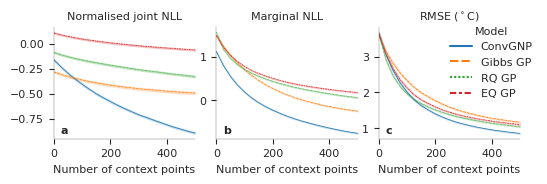

In [54]:

# fig, axes = plt.subplots(figsize=(6,2))
g = sns.relplot(
    data=plot_df,
    col='metric',
    x='Ncontext',
    y='value',
    # style='criterion',
    # markers=True,
    kind='line',
    facet_kws=dict(sharey=False),
    # ci='std',
    hue='Model',
    style='Model',
    errorbar='se',
    legend=True,
    linewidth=0.5,
    height=linewidth / 3,
    aspect=0.8,
)

# for metric in results_df.columns:
#     sns.lineplot(
#         data=results_df,
#         x='N_context_0',
#         y=metric,
#         hue='Model',
#         style='Model',
#         errorbar='se',
#         markers=True,
#     )

titles = ['Normalised joint NLL', 'Marginal NLL', r'RMSE ($^\circ$C)']
for i, (ax, title) in enumerate(zip(g.axes.ravel(), titles)):
    # ax.set_title('')
    # ax.set_ylabel(title)
    ax.set_ylabel('')
    ax.set_title(title)
    ax.set_xlabel('Number of context points')
    ax.set_xlim([0, 500])
    ax.text(0.05, 0.05, string.ascii_lowercase[i], transform=ax.transAxes, weight='bold')
    ax.tick_params(bottom=True, left=True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)

# Get seaborn legend and move it to upper right
sns.move_legend(g, 'upper right', bbox_to_anchor=(1, 0.9), bbox_transform=plt.gcf().transFigure)


In [55]:

fname = f"results_vs_N_context"
fpath = os.path.join(folder, fname)
g.fig.savefig(fpath+'.png', dpi=300, bbox_inches='tight')
g.fig.savefig(fpath+'.pdf', dpi=300, bbox_inches='tight')
print("Plot saved to ", fpath)
plt.close()


Plot saved to  climate_informatics_plots/results_vs_N_context


### Gibbs GP length scale

2023-02-13 16:00:36.389348: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1568000000 exceeds 10% of free system memory.
2023-02-13 16:00:36.539407: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1568000000 exceeds 10% of free system memory.
2023-02-13 16:00:36.651182: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1568000000 exceeds 10% of free system memory.
2023-02-13 16:00:36.844878: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1568000000 exceeds 10% of free system memory.
2023-02-13 16:00:37.160330: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1568000000 exceeds 10% of free system memory.


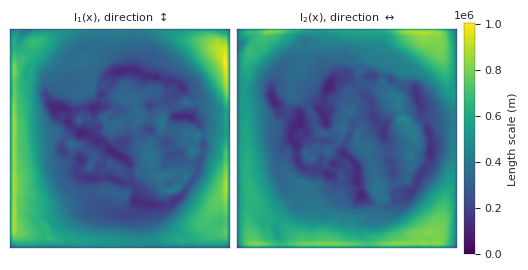

In [93]:
from deepsensor.data.processor import unnormalise
from deepsensor.benchmarks.gp import coords_to_tensor

model = model_dict['Gibbs GP']

n_t = 140
X_target = coords_to_tensor(np.linspace(1, -1, n_t), np.linspace(-1, 1, n_t)).T

lx1 = model.kernel.l_i(X_target)[0].reshape(n_t, -1)
lx2 = model.kernel.l_i(X_target)[1].reshape(n_t, -1)

lx1 = unnormalise(data_processor_ID, region, 'coords', 'y', lx1)
lx2 = unnormalise(data_processor_ID, region, 'coords', 'x', lx2)

max = np.max([lx1, lx2])
clim = [0, max]

gridspec_kw = {'width_ratios': [1, 1, 0.05], 'wspace': 0.05}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 3), gridspec_kw=gridspec_kw)

cmap = 'viridis'

axes[0].imshow(lx1, clim=clim, extent=(-1, 1, -1, 1), cmap=cmap)
axes[0].set_title(r"$l_1(x)$, direction $\updownarrow$")

im = axes[1].imshow(lx2, clim=clim, extent=(-1, 1, -1, 1), cmap=cmap)
axes[1].set_title(r"$l_2(x)$, direction $\leftrightarrow$")

# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, axes[2], label="Length scale (m)")

for ax in axes:
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

plt.tight_layout()

fname = f'gibbs_l_x.pdf'
plt.savefig(os.path.join(folder, fname), dpi=300)
plt.show()
# plt.close()


### Sensor placement results plots

In [179]:
# Criterion rename mapping
cr = {
    'MaxMI': 'JointMI',
    'MaxMarginalMI': 'MarginalMI',
    'MaxDist': 'Remoteness',
    'Random': 'Random',
    'OracleNLL': 'OracleJointNLL',
    'OracleMarginalNLL': 'OracleMarginalNLL',
    'OracleRMSE': 'OracleRMSE',
}
# Reversed criterion rename mapping
crr = {v: k for k, v in cr.items()}

def rename_criteria(df):
    """Rename criteria based on cr dict above to improve readability"""
    df['criterion'] = df['criterion'].map(cr)
    return df

In [180]:
placement_ID = '01_climate_informatics_convgnp_vs_gps'
model_strs = ['ConvGNP', 'Gibbs GP', 'RQ GP', 'EQ GP']
criteria = [cr['MaxMI'], cr['MaxDist'], 'Random']
plot_date = "2009-02-15"

In [181]:
from deepsensor.utils import get_sensor_placement_config

config = get_sensor_placement_config(placement_ID)

In [182]:
results_folder = os.path.join('results', 'sensor_placement', placement_ID)

results_df_list = []
for model_str in model_strs:
    for criterion in config['criteria']:
        results_folder_criterion = os.path.join(results_folder, model_str, criterion)
        results_df_fpath = os.path.join(results_folder_criterion, 'sensor_placement_results.csv')
        df = pd.read_csv(results_df_fpath)
        results_df_list.append(df)

results_df = pd.concat(results_df_list)
results_df = rename_criteria(results_df)
results_df = results_df.set_index(
    ['model', 'criterion', 'seed', 'n_sensors', 'time']).sort_index()
# print(results_df)


In [183]:
time_mean_results_df = results_df.groupby(level=['model', 'criterion', 'seed', 'n_sensors']).mean()
time_mean_results_df

mae      rmse  joint_logpdf  \
model   criterion  seed n_sensors                                     
ConvGNP JointMI    42   0          1.996974  2.700902     -0.121773   
                        1          1.899256  2.573024     -0.109856   
                        2          1.838957  2.495154     -0.099909   
                        3          1.762623  2.403241     -0.090012   
                        4          1.740030  2.376502     -0.080647   
...                                     ...       ...           ...   
RQ GP   Remoteness 42   6          1.645954  2.224576     -0.427560   
                        7          1.628135  2.197993     -0.426036   
                        8          1.600122  2.153095     -0.425793   
                        9          1.589900  2.143079     -0.424268   
                        10         1.565641  2.115615     -0.422503   

                                   mean_marginal_logpdf  \
model   criterion  seed n_sensors                         
ConvGNP JointMI    42   0                     -2.192624   
                        1                     -2.140206   
                        2                     -2.106470   
                        3                     -2.061201   
                        4                     -2.043917   
...                                                 ...   
RQ GP   Remoteness 42   6                     -2.324491   
                        7                     -2.315063   
                        8                     -2.306940   
                        9                     -2.301066   
                        10                    -2.281964   

                                   median_marginal_logpdf  
model   criterion  seed n_sensors                          
ConvGNP JointMI    42   0                       -2.073233  
                        1                       -2.038422  
                        2                       -2.004895  
                        3                       -1.969279  
                        4                       -1.960457  
...                                                   ...  
RQ GP   Remoteness 42   6                       -1.822614  
                        7                       -1.813876  
                        8                       -1.801254  
                        9                       -1.791709  
                        10                      -1.771534  

[352 rows x 5 columns]

Plot saved to climate_informatics_plots/placement_results


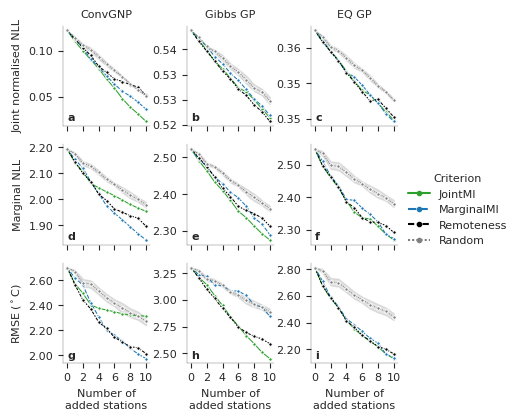

In [184]:
model_strs = ['ConvGNP', 'Gibbs GP', 'EQ GP']
criteria = [cr['MaxMI'], cr['MaxMarginalMI'], cr['MaxDist'], 'Random']

plot_df = time_mean_results_df.loc[model_strs].reset_index()
plot_df[r'RMSE ($^\circ$C)'] = plot_df['rmse']
plot_df['Marginal NLL'] = -plot_df['mean_marginal_logpdf']
plot_df['Joint normalised NLL'] = -plot_df['joint_logpdf']

plot_df['Model'] = plot_df['model']
plot_df['Criterion'] = plot_df['criterion']

metrics = ['Joint normalised NLL', 'Marginal NLL', r'RMSE ($^\circ$C)']
plot_df = plot_df[['Model', 'Criterion', 'seed', 'n_sensors', *metrics]]

# plot_df = time_mean_results_df.reset_index()[['model', 'criterion', 'seed', 'n_sensors', *metrics]]
plot_df = plot_df.melt(id_vars=['Model', 'Criterion', 'seed', 'n_sensors'], var_name='metric')

line_kws = dict(
    palette={
        cr['MaxMI']: sns.color_palette('tab10')[2],
        cr['MaxMarginalMI']: sns.color_palette('tab10')[0],
        'Random': 'gray',
        cr['MaxDist']: 'black',
    },
)

g = sns.relplot(
    data=plot_df,
    col='Model',
    row='metric',
    x='n_sensors',
    y='value',
    hue='Criterion',
    hue_order=criteria,
    # style='Model',
    style='Criterion',
    errorbar='se',
    # linewidth=0.5,
    linewidth=0.75,
    markers=['o'],
    kind='line',
    height=linewidth / 4,
    facet_kws=dict(sharey=False),
    **line_kws,
    markersize=2.5,
    # sharey='row',
    # ci='std',
)

label_i = 0
ylims = []
for row_i in range(g.axes.shape[0]):
    ylims_row = []
    for col_i in range(g.axes.shape[1]):
        ylim = g.axes[row_i, col_i].get_ylim()
        ylims_row.append(ylim)

        ax = g.axes[row_i, col_i]
        if row_i == 0:
            ax.set_title(model_strs[col_i])
        else:
            ax.set_title('')
        if col_i == 0:
            ax.set_ylabel(metrics[row_i])
        else:
            ax.set_ylabel('')
        ax.set_xticks(range(0,config['N_new_sensors']+1, 2))
        ax.set_xlabel('Number of\nadded stations')
        ax.tick_params(bottom=True, left=True)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))

        t = ax.text(0.05, 0.05, string.ascii_lowercase[label_i], transform=ax.transAxes,
                    weight='bold')
        t.set_bbox(dict(facecolor='white', linewidth=0, pad=1))
        label_i += 1

    ylims.append(ylims_row)


# Set ylim to be the same along rows based on min/max values
if False:
    for row_i in range(g.axes.shape[0]):
        ylim = (min([ylim_[0] for ylim_ in ylims[row_i]]),
                max([ylim_[1] for ylim_ in ylims[row_i]]))
        for col_i in range(g.axes.shape[1]):
            ax = g.axes[row_i, col_i]
            ax.set_ylim(ylim)
if False:
    for row_i in range(g.axes.shape[0]):
        ymax = max([ylim_[1] for ylim_ in ylims[row_i]])
        ydiff = max([ylim_[1] - ylim_[0] for ylim_ in ylims[row_i]])
        for col_i in range(g.axes.shape[1]):
            ax = g.axes[row_i, col_i]
            ax.set_ylim((ylims[row_i][col_i][1] - ydiff, ylims[row_i][col_i][1]))

plt.tight_layout()

# Get seaborn legend and move it to upper right
sns.move_legend(g, 'center left', bbox_to_anchor=(0.75, 0.5), bbox_transform=plt.gcf().transFigure, markerscale=0.5)
plt.subplots_adjust(right=0.75)
# plt.tight_layout()

fname = 'placement_results'
fpath = os.path.join(folder, fname)
plt.savefig(fpath+'.png', dpi=300)
plt.savefig(fpath+'.pdf', dpi=300)
print(f"Plot saved to {fpath}")
plt.show()
plt.close()

### Compressed sensor placement results

In [185]:
model_criteria_pairs = [
    ('ConvGNP', cr['MaxMI']),
    ('ConvGNP', cr['MaxMarginalMI']),
    ('ConvGNP', cr['MaxDist']),
    ('ConvGNP', 'Random'),
]

# For these we plot just the best performing criterion by the 10th sensor for each metric
benchmark_models = ['Gibbs GP', 'EQ GP']


In [186]:
model_strs = ['ConvGNP', 'Gibbs GP', 'EQ GP']
criteria = [cr['MaxMI'], cr['MaxMarginalMI'], cr['MaxDist'], 'Random']

# time_and_seed_mean_results_df = results_df.groupby(level=['Model', 'criterion', 'n_sensors']).mean()
time_and_seed_mean_results_df = results_df.groupby(level=['model', 'seed', 'criterion', 'n_sensors']).mean()

plot_df = time_and_seed_mean_results_df.loc[model_strs].reset_index()
plot_df[r'RMSE ($^\circ$C)'] = plot_df['rmse']
plot_df['Marginal NLL'] = -plot_df['mean_marginal_logpdf']
plot_df['Joint normalised NLL'] = -plot_df['joint_logpdf']

plot_df['Model'] = plot_df['model']
plot_df['Criterion'] = plot_df['criterion']

metrics = ['Joint normalised NLL', 'Marginal NLL', r'RMSE ($^\circ$C)']
plot_df = plot_df[['Model', 'Criterion', 'n_sensors', *metrics]]

# plot_df = time_mean_results_df.reset_index()[['Model', 'criterion', 'seed', 'n_sensors', *metrics]]
plot_df = plot_df.melt(id_vars=['Model', 'Criterion', 'n_sensors'], var_name='metric')


In [187]:
df = plot_df.set_index(['Model', 'Criterion', 'n_sensors', 'metric'])
df

value
Model   Criterion n_sensors metric                        
ConvGNP JointMI   0         Joint normalised NLL  0.121773
                  1         Joint normalised NLL  0.109856
                  2         Joint normalised NLL  0.099909
                  3         Joint normalised NLL  0.090012
                  4         Joint normalised NLL  0.080647
...                                                    ...
EQ GP   Random    6         RMSE ($^\circ$C)      2.601168
                  7         RMSE ($^\circ$C)      2.589444
                  8         RMSE ($^\circ$C)      2.582894
                  9         RMSE ($^\circ$C)      2.520618
                  10        RMSE ($^\circ$C)      2.490380

[792 rows x 1 columns]

In [188]:
# Find best criterion for each benchmark model and metric
idxs = df.loc[pd.IndexSlice[benchmark_models, :, 10]].reset_index().groupby(['Model', 'metric']).idxmin()['value']
best_criterion_df = df.loc[pd.IndexSlice[benchmark_models, :, 10]].reset_index().iloc[idxs]
print(best_criterion_df)

       Model   Criterion  n_sensors                metric     value
25     EQ GP  MarginalMI         10  Joint normalised NLL  0.344614
32     EQ GP     JointMI         10          Marginal NLL  2.268240
40     EQ GP     JointMI         10      RMSE ($^\circ$C)  2.129921
3   Gibbs GP  Remoteness         10  Joint normalised NLL  0.520677
8   Gibbs GP     JointMI         10          Marginal NLL  2.274795
16  Gibbs GP     JointMI         10      RMSE ($^\circ$C)  2.451377


In [189]:
best_criterion_df[['metric', 'Model', 'Criterion']]

,metric,Model,Criterion
25,Joint normalised NLL,EQ GP,MarginalMI
32,Marginal NLL,EQ GP,JointMI
40,RMSE ($^\circ$C),EQ GP,JointMI
3,Joint normalised NLL,Gibbs GP,Remoteness
8,Marginal NLL,Gibbs GP,JointMI
16,RMSE ($^\circ$C),Gibbs GP,JointMI


In [190]:
# Include only the best criterion for each benchmark Model
for model, metric, criterion in best_criterion_df[['Model', 'metric', 'Criterion']].values:
    # print(np.sum((plot_df['Model'] == model) & (plot_df['metric'] == metric) & (plot_df['Criterion'] != criterion)))
    plot_df.loc[(plot_df['Model'] == model) & (plot_df['metric'] == metric) & (plot_df['Criterion'] != criterion)] = np.nan
# plot_df2 = plot_df.merge(best_criterion_df[['metric', 'model', 'Criterion']], on=['metric', 'model', 'Criterion'], how='left')
plot_df

,Model,Criterion,n_sensors,metric,value
0,ConvGNP,JointMI,0.0,Joint normalised NLL,0.121773
1,ConvGNP,JointMI,1.0,Joint normalised NLL,0.109856
2,ConvGNP,JointMI,2.0,Joint normalised NLL,0.099909
3,ConvGNP,JointMI,3.0,Joint normalised NLL,0.090012
4,ConvGNP,JointMI,4.0,Joint normalised NLL,0.080647
...,...,...,...,...,...
787,NaN,NaN,NaN,NaN,NaN
788,NaN,NaN,NaN,NaN,NaN
789,NaN,NaN,NaN,NaN,NaN
790,NaN,NaN,NaN,NaN,NaN


Plot saved to climate_informatics_plots/placement_results_compressed


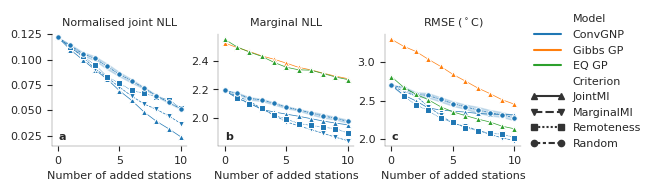

In [191]:
g = sns.relplot(
    data=plot_df,
    col='metric',
    x='n_sensors',
    y='value',
    # style='criterion',
    # markers=True,
    kind='line',
    facet_kws=dict(sharey=False),
    # ci='std',
    hue='Model',
    style='Criterion',
    style_order=[cr['MaxMI'], cr['MaxMarginalMI'], cr['MaxDist'], 'Random'],
    errorbar='se',
    legend=True,
    linewidth=0.5,
    height=linewidth / 3,
    # height=linewidth / 3,
    aspect=1,
    # markers=True,
    markers=['^', 'v', 's', 'o'],
    # **line_kws,
    markersize=2**2,
)

# for metric in results_df.columns:
#     sns.lineplot(
#         data=results_df,
#         x='N_context_0',
#         y=metric,
#         hue='Model',
#         style='Model',
#         errorbar='se',
#         markers=True,
#     )

titles = ['Normalised joint NLL', 'Marginal NLL', r'RMSE ($^\circ$C)']
for i, (ax, title) in enumerate(zip(g.axes.ravel(), titles)):
    # ax.set_title('')
    # ax.set_ylabel(title)
    ax.set_ylabel('')
    ax.set_title(title)
    ax.set_xlabel('Number of added stations')
    # ax.set_xlim([0, 500])
    ax.text(0.05, 0.05, string.ascii_lowercase[i], transform=ax.transAxes, weight='bold')
    ax.tick_params(bottom=True, left=True)

g.axes.ravel()[0].set_ylim([.015, .125])

# for h in g.legend.legendHandles:
#     print(dir(h))
#     h.set_marker('o')

plt.tight_layout()

# Get seaborn legend and move it to upper right
sns.move_legend(g, 'upper left', bbox_to_anchor=(.775, 1), bbox_transform=plt.gcf().transFigure, numpoints=2, handlelength=3, markerscale=.75)

plt.subplots_adjust(wspace=0.23, right=0.775)

fname = 'placement_results_compressed'
fpath = os.path.join(folder, fname)
plt.savefig(fpath+'.png', dpi=300)
plt.savefig(fpath+'.pdf', dpi=300)
print(f"Plot saved to {fpath}")
plt.show()
plt.close()




(0.0, 0.15)

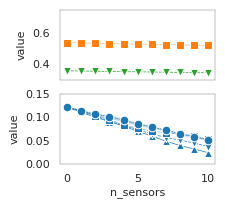

In [192]:
df = plot_df[plot_df.metric == 'Joint normalised NLL']

f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(2, 2))
for ax in axes:
    g = sns.lineplot(
        data=df,
        x='n_sensors',
        y='value',
        # facet_kws=dict(sharey=False),
        hue='Model',
        style='Criterion',
        style_order=[cr['MaxMI'], cr['MaxMarginalMI'], cr['MaxDist'], 'Random'],
        errorbar='se',
        legend=False,
        linewidth=0.5,
        # height=linewidth / 1.75,
        # aspect=0.8,
        markers=['^', 'v', 's', 'o'],
        markersize=2.5**2,
        ax=ax,
    )

axes[0].set_ylim([.3, .75])
axes[1].set_ylim([0, .15])
# ax = sns.tsplot(time=x, data=y, ax=ax1)
# ax = sns.tsplot(time=x, data=y, ax=ax2)


### Encoding visualisations

In [193]:
from deepsensor.plot.utils import plot_encoding

In [194]:

model_str = 'ConvGNP'
model_config = models[model_str]
data_loader = data_loaders[model_config['data_loader_ID']]
model = model_dict[model_str]

In [195]:
dataset = data_loader('2018-06-25', context_sim_locs_date='2009-02-15', context_sim_locs='station')

titles = [
    'Density 1', 'ERA5\ntemperature\nanomaly',
    'Density 2', 'Elevation', 'Land\nmask', r'$\cos(doy)$', r'$\sin(doy)$', r'$x_1$', r'$x_2$',
]

sns.set_style('white')
fig = plot_encoding(model, dataset, data_loader, titles=titles, clim=(-1, 1), cbar=False, size=1.1, cmap='seismic')
# fig.subplots_adjust(hspace=0.6, wspace=0.01)
fig.subplots_adjust(hspace=0.3, wspace=0.00)

fname = f'encoding'
fpath = os.path.join(folder, fname)
plt.savefig(fpath+'.png', dpi=300, bbox_inches='tight')
plt.savefig(fpath+'.pdf', dpi=300, bbox_inches='tight')
plt.close()

### Placements plot combined

In [196]:

placement_ID = '01_climate_informatics_convgnp_vs_gps'
plot_date = "2009-02-15"

model_criterion_pairs = [
    [
        ('ConvGNP', 'MaxMI'),
        ('ConvGNP', 'MaxMarginalMI'),
        ('Gibbs GP', 'MaxMI'),
        ('Gibbs GP', 'MaxMarginalMI'),
        ('EQ GP', 'MaxMI'),
        ('EQ GP', 'MaxMarginalMI'),
        ('EQ GP', 'MaxDist'),
        ('EQ GP', 'Random'),
    ]
]
model_criterion_pairs  = np.array(model_criterion_pairs)

Plot saved to  climate_informatics_plots/placements_combined


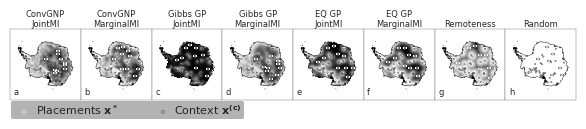

In [197]:

results_folder = os.path.join('results', 'sensor_placement', placement_ID)

nrows = model_criterion_pairs.shape[0]
ncols = model_criterion_pairs.shape[1]
fig, axes = plt.subplots(ncols=ncols, nrows=nrows,
                         figsize=(linewidth, linewidth * nrows / ncols * 1.3),
                         subplot_kw=subplot_kw,
                         # gridspec_kw=gridspec_kw
                         )

if nrows == 1:
    axes = np.array(axes)[np.newaxis, :]

dataset = data_loader(plot_date, context_sim_locs='station')

for i, ax in enumerate(axes.ravel()):
    ax.set_extent((-gb, gb, -gb, gb), crs=ccrs.LambertAzimuthalEqualArea(0, -90))
    # ax.coastlines(linewidth=0.25)
    land_mask.plot.contour(colors='k', levels=[0.5], linewidths=0.25, ax=ax)

label_i = 0
for row_i in range(model_criterion_pairs.shape[0]):
    for col_i in range(model_criterion_pairs.shape[1]):
        model_str, criterion = model_criterion_pairs[row_i, col_i]
        ax = axes[row_i, col_i]

        results_folder_criterion = os.path.join(results_folder, model_str, criterion)
        fpath = os.path.join(results_folder_criterion, f'acquisition_fn_{criterion}.nc')
        acquisition_fn_ds = xr.open_dataarray(fpath)

        if criterion != 'Random':
            g = acquisition_fn_ds.mean(['time', 'sample']).isel(iteration=0).plot(
                cmap='Greys', center=False, ax=ax, add_colorbar=False, add_labels=False,
            )

        # if col_i == 0:
        #     ax.set_yticks([])
        #     # ax.set_ylabel('Acquisition function at\niteration 0, ' + r'$\alpha(x)$')
        #     ax.set_ylabel(r'$\alpha(x)$')

        placement_df = get_placement_df(placement_ID, [model_str], [criterion])
        if criterion == 'Random':
            # Select first seed
            placement_df = placement_df[
                placement_df['seed'] == placement_df['seed'].unique()[1]]
        X_placed = placement_df[['y', 'x']].values.T

        # ax.scatter(*X_placed[::-1], color='g', marker='o', s=3 ** 2, facecolor='none')
        # ax.scatter(*X_placed[::-1], color='g', marker='+', s=3 ** 2, linewidths=0.5)
        if criterion == 'Random':
            ax.scatter(*X_placed[::-1], color='gray', marker='+', s=3 ** 2, linewidths=0.3,
                       label=r'Placements $\bf{x}^*$')
        else:
            ax.scatter(*X_placed[::-1], color='white', marker='+', s=3 ** 2, linewidths=0.3,
                       label=r'Placements $\bf{x}^*$')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        t = ax.text(0.05, 0.07, string.ascii_lowercase[label_i], transform=ax.transAxes, fontsize=6)
        t.set_bbox(dict(facecolor='white', linewidth=0, pad=1))

        if criterion in ['MaxDist', 'Random']:
            ax.set_title(f'{cr[criterion]}', pad=-50, fontsize=6)
        else:
            ax.set_title(f'{model_str}\n{cr[criterion]}', pad=-50, fontsize=6)

        label_i += 1

plot_stations(axes, dataset, data_processor_ID, region, color='k', marker='.', s=2 ** 2,
              linewidths=0.25, label=r'Context $\bf{x}^{(c)}$')

leg = axes[0, 0].legend(bbox_to_anchor=(0, 0), loc='upper left', facecolor=[0.7, 0.7, 0.7], framealpha=1, borderaxespad=0.1, borderpad=0.2, ncol=2, columnspacing=3, handletextpad=0.025, markerscale=2)
leg.get_frame().set_linewidth(0)
# plt.tight_layout()
plt.subplots_adjust(left=0.00, right=1, wspace=0.00, hspace=0.00)

fname = f"placements_combined"
fpath = os.path.join(folder, fname)
plt.savefig(fpath + '.png', dpi=1200, bbox_inches='tight')
plt.savefig(fpath + '.pdf', dpi=1200, bbox_inches='tight')
print("Plot saved to ", fpath)
plt.show()
plt.close()


### Compare acquisition functions with oracle

In [198]:
placement_ID = '01_climate_informatics_convgnp_vs_gps'
model_strs = ['ConvGNP', 'Gibbs GP', 'EQ GP']
model_criteria = ['MaxMI', 'MaxMarginalMI', 'MaxDist']

oracle_placement_ID = "01_climate_informatics_convgnp_vs_gps_oracles"
oracle_criteria = ['OracleNLL', 'OracleMarginalNLL', 'OracleRMSE']
# oracle_criteria = ['OracleNLL', 'OracleMarginalNLL']


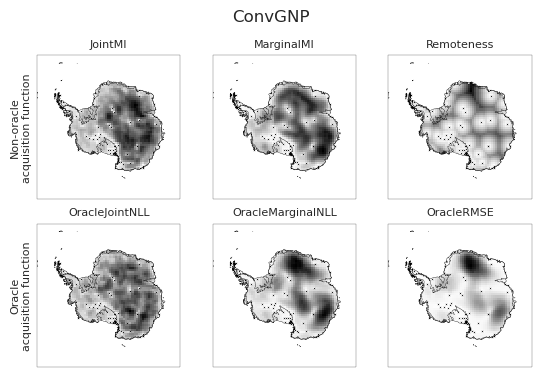

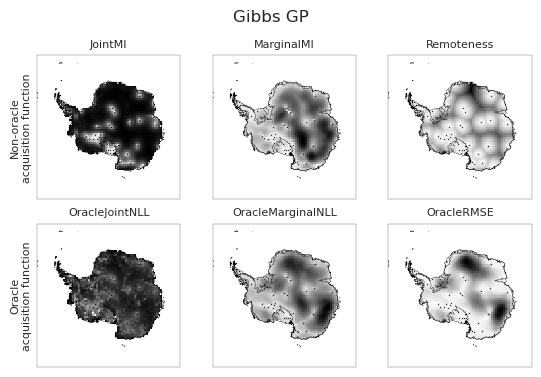

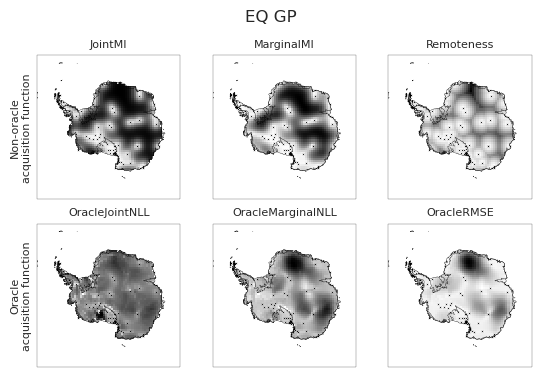

In [199]:
# model_str = 'Gibbs GP'
# placement_ID = '01_climate_informatics_convgnp_vs_gps'
# criterion = cr['MaxMarginalMI']
# criterion = cr['MaxDist']
# criterion = cr['MaxMI']
# plot_date = "2009-02-15"

plot_date = "2009-02-15"
dataset = data_loader(plot_date, context_sim_locs='station')

# Empty pandas dataframe of corr values
corr_values_df = pd.DataFrame(columns=['model', 'criterion', 'oracle_criterion', 'corr'])

for i, model_str in enumerate(model_strs):
    ncols = max(len(model_criteria), len(oracle_criteria))
    nrows = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(linewidth, linewidth * nrows / ncols), subplot_kw=dict(projection=crs))
    plt.suptitle(f'{model_str}')

    gb = 3.5e6
    extent = (-gb, gb, -gb, gb)
    for ax in axes.ravel():
        ax.coastlines(linewidth=0.25)
        land_mask.plot.contour(colors='k', levels=[0.5], linewidths=0.25, ax=ax)
        ax.set_yticks([])
        ax.set_extent(extent, crs=crs)

    for j, model_criterion in enumerate(model_criteria):
        results_folder = os.path.join('results', 'sensor_placement', placement_ID, model_str, model_criterion)
        acquisition_fn_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{model_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)

        acquisition_fn_ds.plot(ax=axes[0, j], add_colorbar=False, cmap='Greys', vmin=acquisition_fn_ds.min(), vmax=acquisition_fn_ds.max())
        if j == 0:
            axes[0, j].set_ylabel('Non-oracle\nacquisition function')
        else:
            axes[0, j].set_ylabel('')
        axes[0, j].set_title(cr[model_criterion])

        for k, oracle_criterion in enumerate(oracle_criteria):
            results_folder = os.path.join('results', 'sensor_placement', oracle_placement_ID, model_str, oracle_criterion)
            oracle_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{oracle_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)

            if j == 0:
                oracle_ds.plot(ax=axes[1, k], add_colorbar=False, cmap='Greys', vmin=oracle_ds.min(), vmax=oracle_ds.max())
                axes[1, k].set_title(cr[oracle_criterion])
                if k == 0:
                    axes[1, k].set_ylabel('Oracle\nacquisition function')
                else:
                    axes[1, k].set_ylabel('')

            # Get flat arrays and remove nan values
            x = oracle_ds.data.flatten()[~np.isnan(oracle_ds.data.flatten())]
            y = acquisition_fn_ds.data.flatten()[~np.isnan(acquisition_fn_ds.data.flatten())]
            r = scipy.stats.pearsonr(x, y)[0]

            # Add to corr values df
            corr_values_df = corr_values_df.append({
                'model': model_str,
                'criterion': cr[model_criterion],
                'oracle_criterion': cr[oracle_criterion],
                'corr': r,
            }, ignore_index=True)
            # print(scipy.stats.pearsonr(x, y))

            # fig, axes = plt.subplots(ncols=2, figsize=(9, 4))
            # acquisition_fn_ds.plot(vmin=0, ax=axes[0])
            # oracle_ds.plot(vmin=0, ax=axes[1])
            # plt.suptitle(f'{model_str} {model_criterion} vs {oracle_criterion}, r={r}')
            # plt.tight_layout()

    plot_stations(axes, dataset, data_processor_ID, region, color='k', marker='x', s=1**2, linewidths=0.25)

    plt.tight_layout()
    fname = f'oracle_comparisons_{model_str}'
    fpath = os.path.join(folder, fname).replace(' ', '_')
    plt.savefig(fpath + '.png', dpi=300)
    plt.savefig(fpath + '.pdf')

In [200]:

print(corr_values_df )

       model   criterion   oracle_criterion      corr
0    ConvGNP     JointMI     OracleJointNLL  0.904041
1    ConvGNP     JointMI  OracleMarginalNLL  0.704522
2    ConvGNP     JointMI         OracleRMSE  0.509778
3    ConvGNP  MarginalMI     OracleJointNLL  0.816644
4    ConvGNP  MarginalMI  OracleMarginalNLL  0.930098
5    ConvGNP  MarginalMI         OracleRMSE  0.789623
6    ConvGNP  Remoteness     OracleJointNLL  0.439422
7    ConvGNP  Remoteness  OracleMarginalNLL  0.763722
8    ConvGNP  Remoteness         OracleRMSE  0.768075
9   Gibbs GP     JointMI     OracleJointNLL  0.589920
10  Gibbs GP     JointMI  OracleMarginalNLL  0.650894
11  Gibbs GP     JointMI         OracleRMSE  0.591378
12  Gibbs GP  MarginalMI     OracleJointNLL  0.412499
13  Gibbs GP  MarginalMI  OracleMarginalNLL  0.860226
14  Gibbs GP  MarginalMI         OracleRMSE  0.588149
15  Gibbs GP  Remoteness     OracleJointNLL  0.536577
16  Gibbs GP  Remoteness  OracleMarginalNLL  0.731592
17  Gibbs GP  Remoteness    

In [201]:
# Pivot dataframe to get matrix of correlation values for each model
for model_str in model_strs:
    corr_values_df_pivot = corr_values_df[corr_values_df['model'] == model_str].pivot(index='criterion', columns='oracle_criterion', values='corr')
    corr_values_df_pivot = corr_values_df_pivot.reindex([cr[c] for c in model_criteria]).T.reindex([cr[c] for c in oracle_criteria])
    # Display 2 decimal places
    with pd.option_context('display.precision', 3):
        print(' '*20 + model_str + '\n')
        print(corr_values_df_pivot)
        print('\n'*2)
    # print(corr_values_df_pivot)
    # sns.heatmap(corr_values_df_pivot, annot=True)
    # plt.title(model_str)
    # plt.show()

                    ConvGNP

criterion          JointMI  MarginalMI  Remoteness
oracle_criterion                                  
OracleJointNLL       0.904       0.817       0.439
OracleMarginalNLL    0.705       0.930       0.764
OracleRMSE           0.510       0.790       0.768



                    Gibbs GP

criterion          JointMI  MarginalMI  Remoteness
oracle_criterion                                  
OracleJointNLL       0.590       0.412       0.537
OracleMarginalNLL    0.651       0.860       0.732
OracleRMSE           0.591       0.588       0.764



                    EQ GP

criterion          JointMI  MarginalMI  Remoteness
oracle_criterion                                  
OracleJointNLL       0.609       0.595       0.597
OracleMarginalNLL    0.646       0.691       0.674
OracleRMSE           0.716       0.762       0.760





 Bootstrapping correlation values

In [202]:

# Empty pandas dataframe of corr values
corr_values_df = pd.DataFrame(columns=['model', 'criterion', 'oracle_criterion', 'corr'])

for i, model_str in enumerate(model_strs):
    for j, model_criterion in enumerate(model_criteria):
        results_folder = os.path.join('results', 'sensor_placement', placement_ID, model_str, model_criterion)
        acquisition_fn_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{model_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)
        for k, oracle_criterion in enumerate(oracle_criteria):
            results_folder = os.path.join('results', 'sensor_placement', oracle_placement_ID, model_str, oracle_criterion)
            oracle_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{oracle_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)

            # Get flat arrays and remove nan values
            x = oracle_ds.data.flatten()[~np.isnan(oracle_ds.data.flatten())]
            y = acquisition_fn_ds.data.flatten()[~np.isnan(acquisition_fn_ds.data.flatten())]
            r = scipy.stats.pearsonr(x, y)[0]

            # Add to corr values df
            corr_values_df = corr_values_df.append({
                'model': model_str,
                'criterion': cr[model_criterion],
                'oracle_criterion': cr[oracle_criterion],
                'corr': r,
            }, ignore_index=True)


In [203]:
# Perform bootstrapping on Pearson correlation values using batches of size 100
n_samples = 1365
n_bootstraps = 1000
bootstrapped_corr_values = np.zeros((n_bootstraps, len(model_strs), len(model_criteria), len(oracle_criteria)))
for i, model_str in enumerate(model_strs):
    for j, model_criterion in enumerate(model_criteria):
        results_folder = os.path.join('results', 'sensor_placement', placement_ID, model_str, model_criterion)
        acquisition_fn_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{model_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)
        for k, oracle_criterion in enumerate(oracle_criteria):
            results_folder = os.path.join('results', 'sensor_placement', oracle_placement_ID, model_str, oracle_criterion)
            oracle_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{oracle_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)

            # Get flat arrays and remove nan values
            x = oracle_ds.data.flatten()[~np.isnan(oracle_ds.data.flatten())]
            y = acquisition_fn_ds.data.flatten()[~np.isnan(acquisition_fn_ds.data.flatten())]

            # Perform bootstrapping
            for b in range(n_bootstraps):
                # Sample with replacement
                idx = np.random.choice(np.arange(len(x)), size=n_samples, replace=True)
                x_sample = x[idx]
                y_sample = y[idx]
                # Calculate correlation
                r = scipy.stats.pearsonr(x_sample, y_sample)[0]
                bootstrapped_corr_values[b, i, j, k] = r

In [204]:
# Calculate mean and standard deviation of bootstrapped correlation values
bootstrapped_corr_values_mean = np.mean(bootstrapped_corr_values, axis=0)
bootstrapped_corr_values_std = np.std(bootstrapped_corr_values, axis=0)

# Calculate 95% confidence intervals directly from percentiles
bootstrapped_corr_values_lower = np.percentile(bootstrapped_corr_values, 2.5, axis=0)
bootstrapped_corr_values_upper = np.percentile(bootstrapped_corr_values, 97.5, axis=0)
# bootstrapped_corr_values_upper = bootstrapped_corr_values_mean + 1.96*bootstrapped_corr_values_std

# Put confidence intervals into pandas dataframe
bootstrapped_corr_values_df_dict = {
    'model': [],
    'Criterion': [],
    'oracle_criterion': [],
    'Correlation': [],
}
for i, model_str in enumerate(model_strs):
    for j, model_criterion in enumerate(model_criteria):
        for k, oracle_criterion in enumerate(oracle_criteria):
            for b in range(n_bootstraps):
                bootstrapped_corr_values_df_dict['model'].append(model_str)
                bootstrapped_corr_values_df_dict['Criterion'].append(cr[model_criterion])
                bootstrapped_corr_values_df_dict['oracle_criterion'].append(cr[oracle_criterion])
                bootstrapped_corr_values_df_dict['Correlation'].append(bootstrapped_corr_values[b, i, j, k])

bootstrapped_corr_values_df = pd.DataFrame(bootstrapped_corr_values_df_dict)

print(bootstrapped_corr_values_df)

         model   Criterion oracle_criterion  Correlation
0      ConvGNP     JointMI   OracleJointNLL     0.909599
1      ConvGNP     JointMI   OracleJointNLL     0.901724
2      ConvGNP     JointMI   OracleJointNLL     0.912763
3      ConvGNP     JointMI   OracleJointNLL     0.906268
4      ConvGNP     JointMI   OracleJointNLL     0.909006
...        ...         ...              ...          ...
26995    EQ GP  Remoteness       OracleRMSE     0.774886
26996    EQ GP  Remoteness       OracleRMSE     0.752121
26997    EQ GP  Remoteness       OracleRMSE     0.778563
26998    EQ GP  Remoteness       OracleRMSE     0.765107
26999    EQ GP  Remoteness       OracleRMSE     0.755872

[27000 rows x 4 columns]


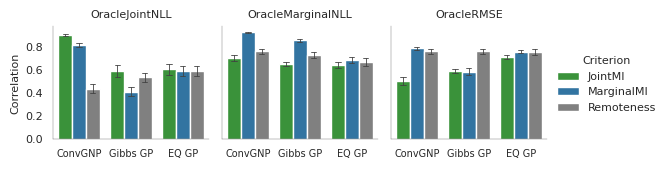

In [205]:
# Plot with seaborn

palette={
    cr['MaxMI']: sns.color_palette('tab10')[2],
    cr['MaxMarginalMI']: sns.color_palette('tab10')[0],
    cr['MaxDist']: 'grey',
}
g = sns.catplot(
    data=bootstrapped_corr_values_df,
    x='model',
    y='Correlation',
    hue='Criterion',
    col='oracle_criterion',
    kind='bar',
    errorbar=('pi', 95),
    height=linewidth / len(model_strs),
    aspect=1,
    capsize=.1,
    errwidth=.6,
    error_kw={'capthick': 0.5, 'alpha': 0.5},
    palette=palette,
)

# Reduce font size
g.set_xticklabels(fontsize=7)

# Replace titles
g.set_titles('{col_name}')

# Remove x label title
g.set_xlabels('')

# plt.tight_layout()
fname = f'correlation_results_plot'
fpath = os.path.join(folder, fname).replace(' ', '_')
plt.savefig(fpath + '.png', dpi=300)
plt.savefig(fpath + '.pdf')



#### Plot model-based acquisition functions against oracle acquisition functions

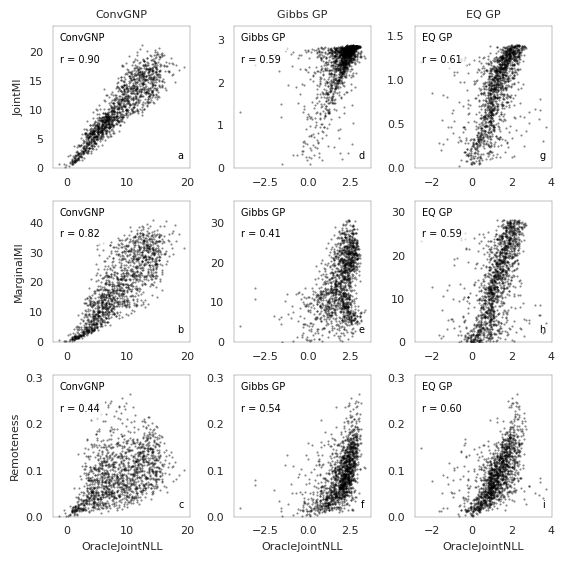

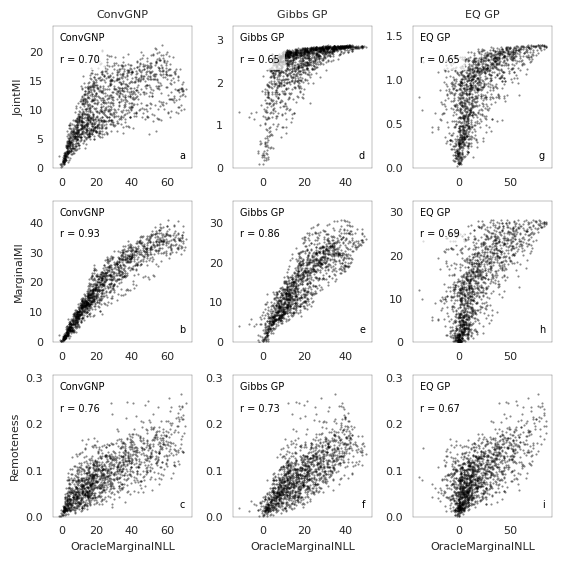

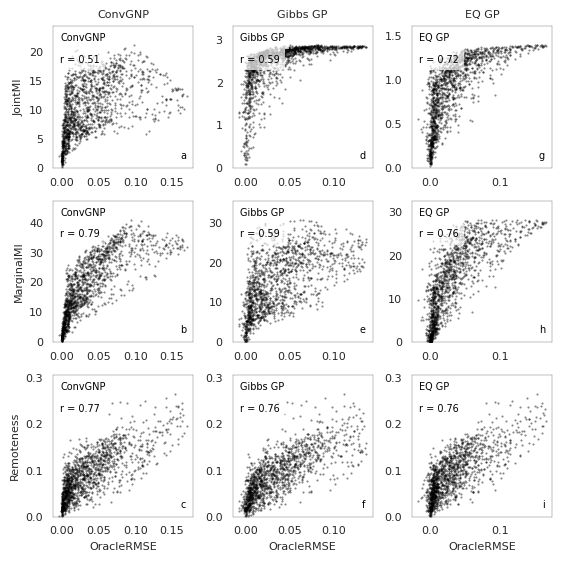

In [206]:
sns.set_style('white')

# Plot model-based acquisition functions against oracle acquisition functions for each oracle criterion
for i, oracle_criterion in enumerate(oracle_criteria):
    fig, axes = plt.subplots(
        len(model_strs),
        len(model_criteria),
        figsize=(linewidth, linewidth),
    )
    # plt.suptitle(f'{cr[oracle_criterion]} oracle acquisition function', fontsize=10)
    label_i = 0
    for j, model_str in enumerate(model_strs):
        results_folder = os.path.join('results', 'sensor_placement', oracle_placement_ID, model_str, oracle_criterion)
        oracle_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{oracle_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)
        for k, model_criterion in enumerate(model_criteria):
            results_folder = os.path.join('results', 'sensor_placement', placement_ID, model_str, model_criterion)
            acquisition_fn_ds = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{model_criterion}.nc')).mean(['time', 'sample']).isel(iteration=0)

            # Get flat arrays and remove nan values
            x = oracle_ds.data.flatten()[~np.isnan(oracle_ds.data.flatten())]
            y = acquisition_fn_ds.data.flatten()[~np.isnan(acquisition_fn_ds.data.flatten())]

            # Plot
            ax = axes[k, j]
            ax.scatter(x, y, s=0.5**2, alpha=0.5, color='k')

            # Add correlation value with white background
            r = scipy.stats.pearsonr(x, y)[0]
            ax.text(0.05, 0.8, f'r = {r:.2f}', transform=ax.transAxes, va='top', ha='left', color='k', fontsize=7, bbox=dict(facecolor='w', edgecolor='none', alpha=0.7))

            # Scale y axis to make space for model text
            ax.set_ylim(0, 1.1*ax.get_ylim()[1])
            ax.text(0.05, 0.95, f'{model_str}', transform=ax.transAxes, va='top', ha='left', color='k', fontsize=7, bbox=dict(facecolor='w', edgecolor='none', alpha=0.7))

            if k == 0:
                ax.set_title(f'{model_str}')
            if j == 0:
                # ax.set_ylabel('Non-oracle\nacquisition function')
                ax.set_ylabel(f'{cr[model_criterion]}')
            if k == len(model_strs) - 1:
                # ax.set_xlabel('Oracle\nacquisition function')
                ax.set_xlabel(f'{cr[oracle_criterion]}')

            # Add subplot label in bottom right corner
            ax.text(0.95, 0.05, string.ascii_lowercase[label_i], transform=ax.transAxes, va='bottom', ha='right', color='k', fontsize=7)
            label_i += 1

    plt.tight_layout()

    fname = f'acquisition_fn_correlation_comparison_{oracle_criterion}'
    fpath = os.path.join(folder, fname).replace(' ', '_')
    plt.savefig(fpath + '.png', dpi=300)
    plt.savefig(fpath + '.pdf')

    plt.show()



### Example multi-objective acquisition function

In [207]:
placement_ID = '01_climate_informatics_convgnp_vs_gps'
placement_ID = '03_climate_informatics_convgnp_only'
model_str = 'ConvGNP'
criterion1 = 'MaxMarginalMI'
criterion2 = 'MaxDist'
criterion3 = 'MaxMI'

plot_date = "2009-02-15"
dataset = data_loader(plot_date, context_sim_locs='station')

# oracle_placement_ID = "01_climate_informatics_convgnp_vs_gps_oracles"
# oracle_criteria = ['OracleNLL', 'OracleMarginalNLL', 'OracleRMSE']

results_folder = os.path.join('results', 'sensor_placement', placement_ID, model_str, criterion1)
acquisition_fn_ds1 = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{criterion1}.nc')).mean(['time', 'sample']).isel(iteration=0)

results_folder = os.path.join('results', 'sensor_placement', placement_ID, model_str, criterion2)
acquisition_fn_ds2 = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{criterion2}.nc')).mean(['time', 'sample']).isel(iteration=0)

results_folder = os.path.join('results', 'sensor_placement', placement_ID, model_str, criterion3)
acquisition_fn_ds3 = xr.open_dataarray(os.path.join(results_folder, f'acquisition_fn_{criterion3}.nc')).mean(['time', 'sample']).isel(iteration=0)

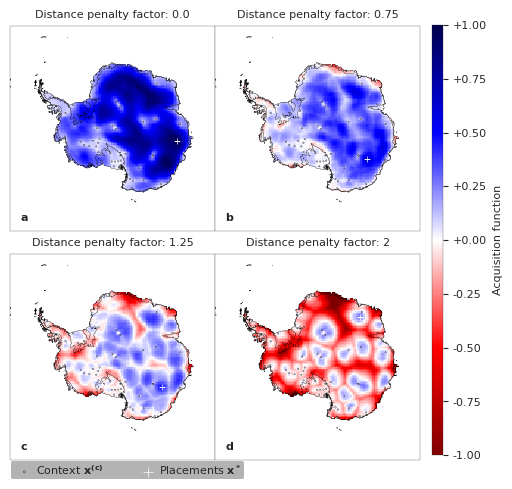

In [208]:

# Normalise
acquisition_fn_ds1_normalised = (acquisition_fn_ds1 - acquisition_fn_ds1.min()) / (acquisition_fn_ds1.max() - acquisition_fn_ds1.min())
acquisition_fn_ds2_normalised = (acquisition_fn_ds2 - acquisition_fn_ds2.min()) / (acquisition_fn_ds2.max() - acquisition_fn_ds2.min())

# Plot
factors = [0., .75, 1.25, 2]
nrows=2
ncols = int(len(factors)/nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(linewidth, linewidth * nrows / ncols), subplot_kw={'projection': crs})

label_i = 0
for factor, ax in zip(factors, axes.ravel()):
    # Subtract
    # factor = 2
    acquisition_fn_ds = acquisition_fn_ds1_normalised - acquisition_fn_ds2_normalised * factor

    # acquisition_fn_ds.plot(cmap='Greys', ax=ax, add_colorbar=False)
    im = acquisition_fn_ds.plot(cmap='seismic_r', ax=ax, add_colorbar=False, vmin=-1, vmax=1)

    extent = (-gb, gb, -gb, gb)
    ax.coastlines(linewidth=0.25)
    land_mask.plot.contour(colors='k', levels=[0.5], linewidths=0.25, ax=ax)
    ax.set_yticks([])
    ax.set_extent(extent, crs=crs)

    # ax.set_title(f'{model_str} {criterion1} - {criterion2} x {factor}')
    ax.set_title(f'Distance penalty factor: {factor}')
    ax.set_ylabel('')
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    plot_stations(ax, dataset, data_processor_ID, region, color='k', marker='.', s=2**2, linewidths=0.25, zorder=20,
                  label=r'Context $\bf{x}^{(c)}$')

    foo = acquisition_fn_ds.where(acquisition_fn_ds==acquisition_fn_ds.max(), drop=True)
    X_placed = np.array([foo.y.values, foo.x.values])
    ax.scatter(*X_placed[::-1], color='white', marker='+', s=5 ** 2, linewidths=0.5,
               label=r'Placements $\bf{x}^*$')

    t = ax.text(0.05, 0.05, string.ascii_lowercase[label_i], transform=ax.transAxes,
                weight='bold')
    t.set_bbox(dict(facecolor='white', linewidth=0, pad=1))
    label_i += 1

plt.subplots_adjust(right=.85, wspace=0, hspace=0.1)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, .76])
cbar_kwargs = dict(fraction=0.0, pad=0.00, format='%+.2f', label='Acquisition function')
cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)

leg = axes[1, 0].legend(bbox_to_anchor=(0, 0), loc='upper left', facecolor=[0.7, 0.7, 0.7], framealpha=1, borderaxespad=0.1, borderpad=0.2, ncol=2, columnspacing=3, handletextpad=0.025, markerscale=1.5)
leg.get_frame().set_linewidth(0)
# plt.tight_layout()
# plt.subplots_adjust(left=0.00, right=1, wspace=0.00, hspace=0.00)

# plt.tight_layout()
fname = f'multiobjective_example'
fpath = os.path.join(folder, fname).replace(' ', '_')
plt.savefig(fpath + '.png', dpi=300)
plt.savefig(fpath + '.pdf')



In [209]:
## Compute pareto optimal solution
from paretoset import paretoset, paretorank


In [210]:
# das = [acquisition_fn_ds1, acquisition_fn_ds2, acquisition_fn_ds3]
das = [acquisition_fn_ds1, acquisition_fn_ds2]
alpha_df = pd.concat([da.to_dataframe(name=f'alpha_{i+1}') for i, da in enumerate(das)], axis=1)
alpha_df = alpha_df.dropna(axis=0)[[f'alpha_{i+1}' for i in range(len(das))]]
alpha_df

alpha_1   alpha_2
y             x                                  
 2.233004e+06 -2.508993e+04   97.710190  0.086479
 2.182824e+06 -7.526978e+04  125.841347  0.068514
              -2.508993e+04  146.696671  0.082515
               2.508993e+04  158.311600  0.096614
               7.526978e+04  172.842545  0.110775
...                                 ...       ...
-2.132644e+06  8.279676e+05   90.751503  0.106047
               8.781475e+05  102.264572  0.112317
               9.283273e+05  111.804688  0.117832
               1.028687e+06  122.242790  0.111919
               1.078867e+06  120.226410  0.111639

[5530 rows x 2 columns]

In [211]:
data = alpha_df.values
senses = ['max', 'min', 'max']
mask = paretoset(data, sense=senses[:len(das)], distinct=False)
rank = paretorank(data, sense=senses[:len(das)], distinct=False)

print(f"Found {mask.sum()} pareto optimal solutions with rank {rank.max()} ranks")


Found 53 pareto optimal solutions with rank 81 ranks


In [212]:
X_pareto = np.array(alpha_df.reset_index()[['y', 'x']])[mask]



In [213]:
rank_da = acquisition_fn_ds1.copy()
rank_da.data[~np.isnan(rank_da.data)] = rank

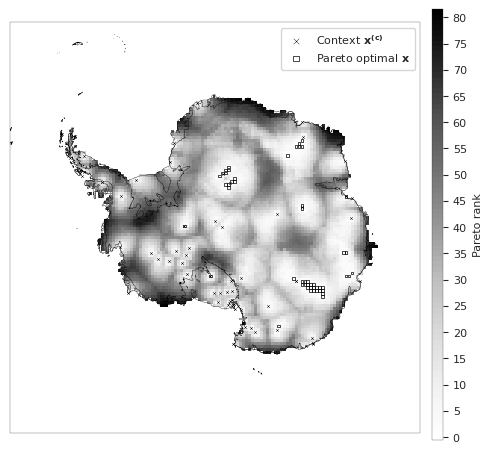

In [214]:
# As above but plot Pareto rank heatmap
fig, ax = plt.subplots(figsize=(linewidth, linewidth), subplot_kw={'projection': crs})
extent = (-gb, gb, -gb, gb)
ax.coastlines('10m', linewidth=0.25)
land_mask.plot.contour(colors='k', levels=[0.5], linewidths=0.25, ax=ax)

ax.set_extent(extent, crs=crs)

plot_stations(ax, dataset, data_processor_ID, region, color='k', marker='x', s=2**2, linewidths=0.3, zorder=20,
              label=r'Context $\bf{x}^{(c)}$')

# Plot pareto rank heatmap with discrete colourbar
# norm = mpl.colors.LinearSegmentedColormap.from_list('mycmap', ['white', 'red'])
norm = mpl.colors.BoundaryNorm(np.arange(0, rank.max() + 2) - 0.5, rank.max() + 1)
im = rank_da.plot.imshow(ax=ax, cmap='Greys', add_colorbar=False, norm=norm)

# Plot pareto optimal solutions with no fill colour
ax.scatter(*X_pareto.T[::-1], color='k', marker='s', s=2**2, linewidths=0.5, facecolors='none',
           label=r'Pareto optimal $\bf{x}$')

ax.legend(markerscale=2)

ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

plt.subplots_adjust(right=.85, wspace=0, hspace=0.1)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, .76])
cbar_kwargs = dict(fraction=0.0, pad=0.00, label='Pareto rank', ticks=np.arange(0, rank.max() + 1, 5))
cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)
cb.ax.minorticks_off()

fname = f'pareto_optimal_and_rank'
fpath = os.path.join(folder, fname).replace(' ', '_')
plt.savefig(fpath + '.png', dpi=300)
plt.savefig(fpath + '.pdf')


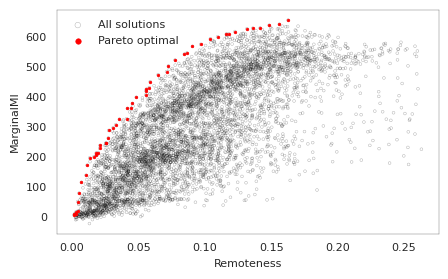

In [215]:
fig, ax = plt.subplots(figsize=(0.8*linewidth, 0.5*linewidth))
ax.scatter(acquisition_fn_ds2.data.flatten(), acquisition_fn_ds1.data.flatten(), marker='o', color='k',s=2**2, linewidths=0.35, label='All solutions', facecolor='none', alpha=0.3)
y_pareto = alpha_df.reset_index()[['alpha_1', 'alpha_2']].values[mask]
plt.scatter(y_pareto[:, 1], y_pareto[:, 0], marker='o', color='r', s=2**2,linewidths=0.35, label='Pareto optimal')
ax.legend(loc='upper left', frameon=False, markerscale=2)
ax.set_ylabel(cr[criterion1])
ax.set_xlabel(cr[criterion2])
# ax.set_xlabel(r'$\alpha_1$')

plt.tight_layout()

fname = f'pareto_optimal_scatter'
fpath = os.path.join(folder, fname).replace(' ', '_')
plt.savefig(fpath + '.png', dpi=300)
plt.savefig(fpath + '.pdf')